## Import Modules

Scipy provides the *least_squares* optimization function

In [1]:
# Pandas and table
import pandas as pd
# Opimization
from scipy.optimize import least_squares
import numpy as np
# Plotting curve
import matplotlib.pylab as plt

## Definition of the model function used to fit the data
In the following example we will fit experimantal data with the ***Ogden model***

$\sigma_{\text{eng uniax}} = \displaystyle\sum_{p=1}^n 2\mu_{p} \left[\lambda^{(\alpha_{p}-1)} - \lambda^{-(1/2\alpha_{p}+1)}\right]$

For a 3rd order model, we have 6 parameters : $\mu_{1}, \alpha_{1}, \mu_{2}, \alpha_{2}, \mu_{3}, \alpha_{3}$

In [2]:
def OgdenModel(trueStrain, parameters, order):
    """Ogden hyperelastic model (incompressible material under uniaxial tension)
    Uses true strain and true stress data"""
                
    # parameter is a 1D array : [mu0,mu1,...,mun,alpha0,alpha1,...,alphan] 
    muVec = parameters.reshape(2, order)[0]
    alphaVec = parameters.reshape(2, order)[1]
    lambd = np.exp(trueStrain)
    # broadcasting method to speed up computation
    lambd = lambd[np.newaxis, :]
    muVec = muVec[:order, np.newaxis]
    alphaVec = alphaVec[:order, np.newaxis]
        
    trueStress = np.sum(2*muVec*(lambd**(alphaVec - 1) - lambd**(-((1/2)*alphaVec + 1))), axis=0)
    return trueStress

## Definition of the cost function

The aim of the optimisation algorithm is to minimize the Residual Sum of Squares

$\textit{Residual Sum of Squares} = \displaystyle\sum_{i=1}^n \left(\sigma_{model} - \sigma_{data}\right)^{2}$

In [3]:
# cost function to calculate the residuals. The fitting function holds the parameter values.  
def objectiveFun_Callback(parameters, exp_strain, exp_stress):  
    theo_stress = OgdenModel(exp_strain, parameters, order)   
    residuals = theo_stress - exp_stress 
    return residuals

## Read Experimental data

In [4]:
file = 'DragonSkin20.csv' # Replace space by %20 for html url 
header = pd.read_csv(file, delimiter = ';', usecols = ["PARAMETER", "INFO", "URL"]).head(15)
data = pd.read_csv(file, delimiter = ';',skiprows=18, names = ['Time (s)','True Strain','True Stress (MPa)','Engineering Strain','Engineering Stress (MPa)']) # the column headers are on line 16 from the top of the file

In [5]:
header

,PARAMETER,INFO,URL
0,Specimen Thickness (mm),3,NaN
1,Specimen Width (mm),6,NaN
2,Specimen Length (mm),33,NaN
3,Specimen Cross-section (cm^2),0.18,NaN
4,Standard,ASTM D412,NaN
5,Type of test,Pull-to-failure,NaN
6,Speed (mm/min),450,NaN
7,Machine,Instron 5569,NaN
8,Load Cell,1 kN - Instron 2525-806,NaN
9,Grippers,Instron 2710-010,NaN


In [6]:
data

,Time (s),True Strain,True Stress (MPa),Engineering Strain,Engineering Stress (MPa)
0,0.2,0.043637,0.009762,0.044600,0.009343
1,0.3,0.065743,0.019337,0.067950,0.018107
2,0.4,0.086950,0.028433,0.090843,0.026063
3,0.5,0.107613,0.036371,0.113620,0.032660
4,0.6,0.127830,0.044294,0.136360,0.038980
...,...,...,...,...,...
399,40.1,2.313885,44.406199,9.113635,4.390725
400,40.2,2.316130,44.617326,9.136365,4.401710
401,40.3,2.318370,44.835612,9.159090,4.413350
402,40.4,2.320600,45.047888,9.181820,4.424345


In [7]:
exp_strain = data['True Strain'].values        # .values converts panda series to numy array
exp_stress = data['True Stress (MPa)'].values

## Least square optimisation function

In [8]:
order = 3
initialGuessMu = np.array([0.1]*order)     # ["µ1","µ2","µ3"]
initialGuessAlpha = np.array([0.2]*order)  # ["α1","α2","α3"]
initialGuessParam = np.append(initialGuessMu,initialGuessAlpha)
nbparam = order*2
param_names = ["µ1","µ2","µ3","α1","α2","α3"]

In [9]:
# The least_squares package calls the Levenberg-Marquandt algorithm.
# best-fit paramters are kept within optim_result.x
optim_result = least_squares(objectiveFun_Callback, initialGuessParam, method ='lm', args=(exp_strain, exp_stress))
optim_parameters = optim_result.x
   
theo_stress = OgdenModel(exp_strain, optim_parameters, order)

## Results

In [10]:
print('optimised parameters:')
print('µ1=' + str(optim_parameters[0]))
print('µ2=' + str(optim_parameters[1]))
print('µ3=' + str(optim_parameters[2]))
print('α1=' + str(optim_parameters[3]))
print('α2=' + str(optim_parameters[4]))
print('α3=' + str(optim_parameters[5]))

optimised parameters:
µ1=0.007410965928874807
µ2=0.08212784341342322
µ3=0.011386289820264345
α1=3.336147096585031
α2=3.336174331775407
α3=3.336183246693289


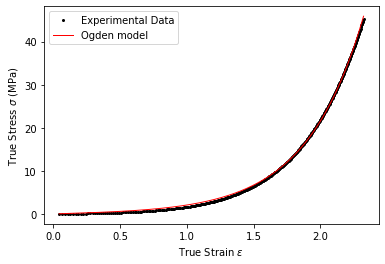

In [11]:
# Plotting the data
plt.plot(exp_strain,exp_stress,'k', marker="o", markersize=2, linestyle = 'None')
plt.plot(exp_strain,theo_stress,'r', linewidth=1)
#plt.title('Least-squares fit to data')
plt.xlabel('True Strain ' + r'$ \epsilon$')
plt.ylabel('True Stress ' +  r'$ \sigma$' + ' (MPa)')
plt.legend(['Experimental Data', 'Ogden model'],loc=2)
plt.grid(visible=None, which='both', axis='both')

In [12]:
# Define the strain value you want to evaluate
desired_strain = np.array([1.0])

# Compute the true stress using the Ogden model for strain=1.0
desired_stress = OgdenModel(desired_strain, optim_parameters, order)

print(desired_stress[0])

2.0734460377039805


Text(0, 0.5, '$\\Delta P_{open}$ [Pa]')

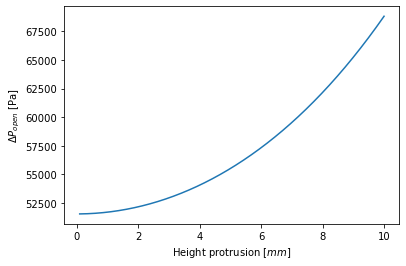

In [25]:
ID = 4e-3 # m
t_inlet = 2e-3# m
D=30e-3 #m
t_membrane=1e-3 #m
A_membrane = D*t_membrane #m2

l0 = D 
h = np.linspace(0.1,10,40)*1e-3
l1= np.array(2*np.sqrt((D-(ID+2*t_inlet)/2)**2+h**2)+ID+2*t_inlet)
stress_membrane = OgdenModel(l1/l0, optim_parameters, order) #Mpa [N/mm2]
stress_membrane
F_membrane=stress_membrane*(A_membrane*1e6) #N
A_inlet = np.pi/4*ID**2 #M2
P_open = F_membrane/A_inlet #N/m2
plt.plot(h*1000,P_open/1000)
plt.xlabel('Height protrusion [$mm$]')
plt.ylabel('$\\Delta P_{open}$ [Pa]')

In [41]:
l1/l0

array([2.00001282, 2.00016051, 2.00047338, 2.00095134, 2.00159424,
       2.00240192, 2.00337412, 2.00451059, 2.005811  , 2.00727498,
       2.00890211, 2.01069195, 2.01264399, 2.01475769, 2.01703246,
       2.01946767, 2.02206267, 2.02481673, 2.02772912, 2.03079905,
       2.03402569, 2.0374082 , 2.04094568, 2.0446372 , 2.04848181,
       2.05247853, 2.05662632, 2.06092414, 2.06537093, 2.06996556,
       2.07470693, 2.07959387, 2.08462522, 2.08979978, 2.09511632,
       2.10057362, 2.10617043, 2.11190547, 2.11777746, 2.1237851 ])

In [42]:
import numpy as np

def compute_P_open(h, optim_parameters, order, ID, t_inlet, D, t_membrane):
    """
    Computes P_open for given height values and Ogden parameters.
    
    Parameters:
    - h: Array of height values of the protrusion
    - optim_parameters: Optimized parameters for the Ogden model
    - order: Order of the Ogden model
    - ID: internal diameter inlet, t_inlet: thickness of protrusion, D = dimater membrane, t_membrane = thickness membrane
    
    Returns:
    - P_open: Array of P_open values for the given height values
    """
    
    # Derived parameters
    A_membrane = D * t_membrane
    print('Area is '+str(A_membrane))
    l0 = D
    l1 = 2 * np.sqrt((D - (ID + 2*t_inlet) / 2)**2 + h**2) + ID + 2*t_inlet
    
    # Compute the membrane stress using the Ogden model
    stress_membrane = OgdenModel((l1-l0)/l0, optim_parameters, order) #MPa = N/mm2
    
    # Compute the force on the membrane
    F_membrane = stress_membrane * (A_membrane*1e6) #N/mm2*mm2 = N
    print('Force'+str(F_membrane))
    
    # Compute the area of the inlet
    A_inlet = np.pi / 4 * ID**2
    
    # Compute P_open
    P_open = F_membrane / A_inlet 
    
    return P_open


Area is 3e-06
Force[6.22052712 6.22270486 6.22732056 6.23437815 6.24388365 6.25584519
 6.27027299 6.28717937 6.3065788  6.3284879  6.35292544 6.37991238
 6.40947192 6.44162947 6.47641272 6.51385168 6.55397868 6.59682844
 6.64243811 6.69084728 6.74209806 6.79623514 6.85330581 6.91336001
 6.97645045 7.04263261 7.11196481 7.18450834 7.26032744 7.33948945
 7.42206488 7.50812744 7.59775419 7.69102559 7.78802563 7.88884189
 7.99356566 8.10229207 8.21512016 8.33215304]
Area is 1.7e-05
Force[35.24965366 35.26199422 35.28814984 35.32814284 35.38200737 35.44978943
 35.53154692 35.62734974 35.73727986 35.86143142 35.99991081 36.15283685
 36.32034089 36.50256699 36.69967209 36.91182618 37.13921252 37.38202785
 37.64048261 37.91480123 38.20522235 38.51199914 38.83539957 39.17570674
 39.53321924 39.90825144 40.30113394 40.7122139  41.14185547 41.59044024
 42.05836764 42.54605549 43.0539404  43.58247836 44.13214524 44.70343736
 45.29687208 45.91298839 46.5523476  47.21553392]
Area is 3.09999999999999

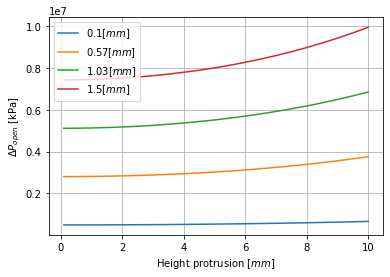

In [45]:
h_values = np.linspace(0.1, 10, 40) * 1e-3  # Vary height of inlet 
t_values= np.linspace(0.1,1.5,4)*1e-3 #vary thickness of membrane 
ID = 4e-3 # internal diameter of the inlet [m]
t_inlet = 2e-3#  thickness of the inlet [m]
D=30e-3 # Diameter membrane [m]

for thickness in t_values:
    P_open_values = compute_P_open(h_values, optim_parameters, order, ID, t_inlet, D, thickness)
    plt.plot(h_values*1000,P_open_values,label=str(round(thickness*1000,2))+'[$mm$]')
    
plt.xlabel('Height protrusion [$mm$]')
plt.ylabel('$\\Delta P_{open}$ [kPa]')
plt.legend()
plt.grid()

print(P_open_values)